## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import sys

import skimage
from skimage.color import rgb2hsv
from skimage.transform import rescale, resize
from tqdm import tqdm

import sys
import os

from sklearn.metrics import classification_report


import bz2, pickle, _pickle as cPickle

import random

# random.seed(1234)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Modules\\Testing")
import testing_module

SAVE_DIR = "../Pickled Datasets/"

HEIGHT = 25
WIDTH  = 25


def compressed_pickle(name: str, data):
    with bz2.BZ2File(os.path.join(SAVE_DIR, "{}.pbz2".format(name)), 'w') as f:
        cPickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

    

SKImage rescales the image for us! Which means that we don't need to rescale by 255.0 anymore, saving us needlessly spent time and effort. There is another Augmentor library which can be used for data augmentation. We can simply sample the augmented images henceforth!

## Preliminary setup

In [2]:
sys.path.append(os.path.dirname(os.path.join((os.path.pardir), "Modules")))

origin_dir = os.path.join(os.path.pardir, 'Data')
new_dir_path = os.path.join(os.path.pardir, 'Data', 'cell_images')

#for local systems
train_csv = os.path.join(origin_dir, 'train.csv')
test_csv = os.path.join(origin_dir, 'test.csv')
val_csv = os.path.join(origin_dir, 'val.csv')

from Modules.labelling import Labelling

# download = Data_Download(origin_dir)
# data_dir = download.resize_image(new_dir_path, 44, 44)

lab = Labelling()
lab.label('../Data/cell_images/', exclude_mislabeled= True)      # function to label the dataset
train_csv, val_csv, test_csv = lab.train_test_val_split('../Data/', '../Data/cell_images/labels.csv', random_state = 1234)

In [3]:
train_data = pd.read_csv(train_csv)
val_data   = pd.read_csv(val_csv)
test_data  = pd.read_csv(test_csv)

### Reading images

In [4]:
def read_image(path):
    '''Function to read images given a path and return an array'''
    return skimage.io.imread(path)

../Data/cell_images/Parasitized\C39P4thinF_original_IMG_20150622_105102_cell_95.png
0.9966666666666667


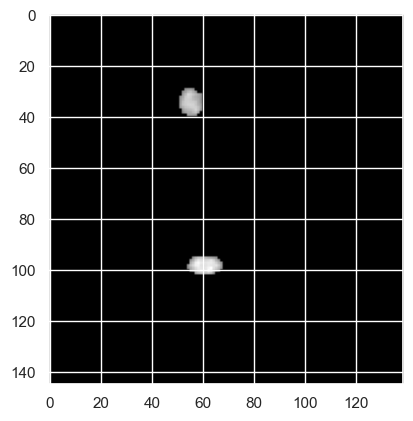

In [5]:
i = 14

print(train_data['Image_Path'][i])
image = rgb2hsv(skimage.io.imread(train_data['Image_Path'][i]))
print(np.max(image))
result = ((image > 0.5)*image)[..., 1]
plt.imshow(result, 'gray')

In [6]:
tqdm.pandas()
train_data['image_arr'] = train_data['Image_Path'].progress_apply(lambda x: read_image(x))
val_data['image_arr']   = val_data['Image_Path'].progress_apply(lambda x: read_image(x))
test_data['image_arr']  = test_data['Image_Path'].progress_apply(lambda x: read_image(x))


x_train, y_train = train_data['image_arr'].to_numpy(), train_data['Parasitized'].to_numpy()
x_val  , y_val   = val_data['image_arr'].to_numpy()  , val_data['Parasitized'].to_numpy()
x_test , y_test  = test_data['image_arr'].to_numpy() , test_data['Parasitized'].to_numpy()

100%|██████████| 2617/2617 [00:03<00:00, 673.35it/s]


## Data Augmentation

In [7]:
import albumentations as A
import cv2

In [32]:
augment = A.augmentations.geometric.transforms.Affine(
    translate_percent = 0.1,
    rotate = 60,
    shear = 30
    )

augment = A.ShiftScaleRotate(rotate_limit= 180, border_mode=cv2.BORDER_CONSTANT, always_apply= True)

transform = A.Compose(
    [augment,
    A.VerticalFlip(p = 0.5),
    A.HorizontalFlip(p = 0.5),
    A.augmentations.geometric.Affine(shear = 15),
    A.Resize(HEIGHT, WIDTH, always_apply= True)
    ]
)

aug_dataset = []
aug_labels = []
COPIES = 2

for i, lab in tqdm(zip(x_train, y_train)):
    for _ in range(COPIES):
        aug_dataset.append(transform(image = i)['image'])
        aug_labels.append(lab)

20601it [00:05, 3576.25it/s]


In [33]:
x_train_aug = np.array(aug_dataset)
y_train_aug = np.array(aug_labels)

In [34]:
np.unique(y_train_aug, return_counts = True)

(array([0., 1.]), array([20520, 20682], dtype=int64))

### Resizing

In [10]:
temp = []
for img in tqdm(x_train):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_train = np.array(temp)


temp = []
for img in tqdm(x_val):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_val = np.array(temp)


temp = []
for img in tqdm(x_test):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_test = np.array(temp)

100%|██████████| 2617/2617 [00:02<00:00, 1094.98it/s]


## Saving Data

In [35]:
compressed_pickle("x_train_aug", x_train_aug)
compressed_pickle("y_train_aug", y_train_aug)
compressed_pickle("x_train", x_train)
compressed_pickle("y_train", y_train)
compressed_pickle("x_val", x_val)
compressed_pickle("y_val", y_val)
compressed_pickle("x_test", x_test)
compressed_pickle("y_test", y_test)

## Loading Data

In [12]:
x_train_aug = decompress_pickle(SAVE_DIR + 'x_train_aug.pbz2')
y_train_aug = decompress_pickle(SAVE_DIR + 'y_train_aug.pbz2')
x_train = decompress_pickle(SAVE_DIR + 'x_train.pbz2')
y_train = decompress_pickle(SAVE_DIR + 'y_train.pbz2')
x_val = decompress_pickle(SAVE_DIR + 'x_val.pbz2')
y_val = decompress_pickle(SAVE_DIR + 'y_val.pbz2')
x_test = decompress_pickle(SAVE_DIR + 'x_test.pbz2')
y_test = decompress_pickle(SAVE_DIR + 'y_test.pbz2')

print("augmented: ", x_train_aug.shape, y_train_aug.shape)
print("train: ", x_train.shape, y_train.shape)
print("val: ", x_val.shape, y_val.shape)
print("test: ", x_test.shape, y_test.shape)

augmented:  (41202, 25, 25, 3) (41202,)
train:  (20601, 25, 25, 3) (20601,)
val:  (2943, 25, 25, 3) (2943,)
test:  (2617, 25, 25, 3) (2617,)


In [13]:
n_aug_train = x_train_aug.shape[0]
n_train     = x_train.shape[0]
n_val       = x_val.shape[0]
n_test      = x_test.shape[0]

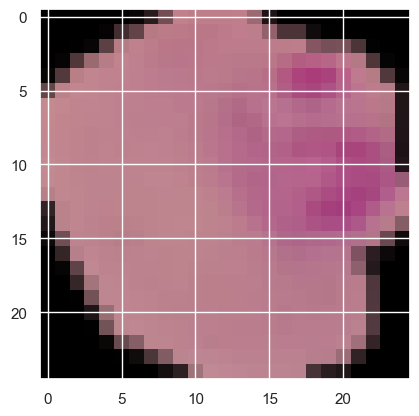

In [14]:
plt.imshow(x_train[3])

## Modeling

In [15]:
N_DIGITS = 3

### Unaugmented

#### Naive Bayes

In [16]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = nb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.611     0.746     0.672     10260
         1.0      0.677     0.530     0.594     10341

    accuracy                          0.637     20601
   macro avg      0.644     0.638     0.633     20601
weighted avg      0.644     0.637     0.633     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.620     0.761     0.683      1466
         1.0      0.693     0.538     0.606      1477

    accuracy                          0.649      2943
   macro avg      0.657     0.649     0.644      2943
weighted avg      0.657     0.649     0.644      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.613     0.766     0.681      1303
         1.0      0.692     0.521     0.595      1314

    accuracy                          0.643      2617
   macro avg      0.653

#### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  LogisticRegression(max_iter = 200, verbose = 10, n_jobs = -1, solver = 'saga')
logreg_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = logreg_cls.predict(x_train.reshape(n_train, -1))
preds_val   = logreg_cls.predict(x_val.reshape(n_val, -1))
preds_test  = logreg_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


max_iter reached after 43 seconds
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.729     0.754     0.741     10260
         1.0      0.747     0.722     0.734     10341

    accuracy                          0.738     20601
   macro avg      0.738     0.738     0.738     20601
weighted avg      0.738     0.738     0.738     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.693     0.714     0.703      1466
         1.0      0.707     0.686     0.696      1477

    accuracy                          0.700      2943
   macro avg      0.700     0.700     0.700      2943
weighted avg      0.700     0.700     0.700      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.689     0.738     0.712      1303
         1.0      0.720     0.670     0.694      1314

    accuracy                          0.703

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   43.3s finished


#### Decision Trees

In [19]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 5, min_samples_split = 2, )
dt_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = dt_cls.predict(x_train.reshape(n_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.685     0.774     0.727     10260
         1.0      0.743     0.646     0.691     10341

    accuracy                          0.710     20601
   macro avg      0.714     0.710     0.709     20601
weighted avg      0.714     0.710     0.709     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.677     0.774     0.722      1466
         1.0      0.738     0.634     0.682      1477

    accuracy                          0.703      2943
   macro avg      0.708     0.704     0.702      2943
weighted avg      0.708     0.703     0.702      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.662     0.748     0.703      1303
         1.0      0.714     0.622     0.664      1314

    accuracy                          0.685      2617
   macro avg      0.688

#### XGBoost

In [20]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 5, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = xgb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.966     0.983     0.974     10260
         1.0      0.983     0.966     0.974     10341

    accuracy                          0.974     20601
   macro avg      0.974     0.974     0.974     20601
weighted avg      0.975     0.974     0.974     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.842     0.873     0.857      1466
         1.0      0.869     0.837     0.853      1477

    accuracy                          0.855      2943
   macro avg      0.855     0.855     0.855      2943
weighted avg      0.855     0.855     0.855      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.842     0.861     0.851      1303
         1.0      0.859     0.839     0.849      1314

    accuracy                          0.850      2617
   macro avg      0.850

#### SVM

In [21]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'rbf', max_iter = 250, verbose= True)
svm_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = svm_cls.predict(x_train.reshape(n_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.456     0.498     0.476     10260
         1.0      0.452     0.411     0.430     10341

    accuracy                          0.454     20601
   macro avg      0.454     0.454     0.453     20601
weighted avg      0.454     0.454     0.453     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.446     0.477     0.461      1466
         1.0      0.442     0.412     0.426      1477

    accuracy                          0.444      2943
   macro avg      0.444     0.444     0.444      2943
weighted avg      0.444     0.444     0.444      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.457     0.486     0.471      1303
         1.0      0.456     0.428     0.441      1314

    accuracy                          0.457      2617
   macro avg      0.457

#### Transfer Learning

In [22]:
imagenet = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (72, 72, 3)
)
imagenet.trainable = False

trans_learn = tf.keras.Sequential([
    tf.keras.layers.Resizing(72, 72),
    imagenet,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

trans_learn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = trans_learn.fit(
            x_train, y_train, batch_size = 64,
            shuffle = True,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 32,
            callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
        )
preds_train = np.argmax(trans_learn.predict(x_train), axis = 1)
preds_val   = np.argmax(trans_learn.predict(x_val), axis = 1)
preds_test  = np.argmax(trans_learn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))



Epoch 1/50
322/322 [==============================] - 9s 17ms/step - loss: 0.2140 - accuracy: 0.9201 - val_loss: 0.1365 - val_accuracy: 0.9514
Epoch 2/50
322/322 [==============================] - 5s 15ms/step - loss: 0.1240 - accuracy: 0.9504 - val_loss: 0.1341 - val_accuracy: 0.9470
Epoch 3/50
322/322 [==============================] - 5s 15ms/step - loss: 0.1077 - accuracy: 0.9583 - val_loss: 0.1331 - val_accuracy: 0.9531
Epoch 4/50
322/322 [==============================] - 5s 16ms/step - loss: 0.0971 - accuracy: 0.9615 - val_loss: 0.1074 - val_accuracy: 0.9630
Epoch 5/50
322/322 [==============================] - 5s 15ms/step - loss: 0.0927 - accuracy: 0.9634 - val_loss: 0.1137 - val_accuracy: 0.9623
Epoch 6/50
322/322 [==============================] - 5s 15ms/step - loss: 0.0866 - accuracy: 0.9669 - val_loss: 0.2217 - val_accuracy: 0.9320
Epoch 7/50
82/82 [==============================] - 1s 7ms/step
Training Classification Report: 
               precision    recall  f1-score 

#### CNN Model

In [23]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = x_train[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train, y_train, batch_size = 1024,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 256,
            callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
        )
preds_train = np.argmax(cnn.predict(x_train), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Epoch 1/50
21/21 [==============================] - 1s 16ms/step - loss: 0.6991 - accuracy: 0.5436 - val_loss: 0.6575 - val_accuracy: 0.5906
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 0.6421 - accuracy: 0.6313 - val_loss: 0.5956 - val_accuracy: 0.6854
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5946 - accuracy: 0.6853 - val_loss: 0.6197 - val_accuracy: 0.6232
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5464 - accuracy: 0.7279 - val_loss: 0.5453 - val_accuracy: 0.7159
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5019 - accuracy: 0.7666 - val_loss: 0.9244 - val_accuracy: 0.5070
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 0.6034 - accuracy: 0.6656 - val_loss: 0.5038 - val_accuracy: 0.7530
Epoch 7/50
21/21 [==============================] - 0s 7ms/step - loss: 0.4677 - accuracy: 0.7900 - val_loss: 0.4338 - val_accuracy: 0.8073
Epoch 8/50
21/21 [=

### Augmented Dataset

#### Naive Bayes

In [36]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = nb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.615     0.733     0.669     20520
         1.0      0.673     0.544     0.601     20682

    accuracy                          0.638     41202
   macro avg      0.644     0.638     0.635     41202
weighted avg      0.644     0.638     0.635     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.605     0.815     0.694      1466
         1.0      0.720     0.471     0.570      1477

    accuracy                          0.643      2943
   macro avg      0.662     0.643     0.632      2943
weighted avg      0.662     0.643     0.632      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.604     0.813     0.693      1303
         1.0      0.717     0.471     0.569      1314

    accuracy                          0.641      2617
   macro avg      0.661

#### Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  LogisticRegression(max_iter = 200, verbose = 10, n_jobs = -1, solver = 'saga')
logreg_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = logreg_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = logreg_cls.predict(x_val.reshape(n_val, -1))
preds_test  = logreg_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


max_iter reached after 88 seconds
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.681     0.724     0.702     20520
         1.0      0.708     0.663     0.685     20682

    accuracy                          0.694     41202
   macro avg      0.694     0.694     0.693     41202
weighted avg      0.694     0.694     0.693     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.657     0.731     0.692      1466
         1.0      0.699     0.622     0.659      1477

    accuracy                          0.676      2943
   macro avg      0.678     0.676     0.675      2943
weighted avg      0.679     0.676     0.675      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.659     0.732     0.694      1303
         1.0      0.701     0.624     0.660      1314

    accuracy                          0.678

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.5min finished


#### Decision Trees

In [38]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 20, min_samples_split = 2, )
dt_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = dt_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.859     0.962     0.908     20520
         1.0      0.957     0.844     0.897     20682

    accuracy                          0.903     41202
   macro avg      0.908     0.903     0.902     41202
weighted avg      0.908     0.903     0.902     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.690     0.802     0.741      1466
         1.0      0.765     0.642     0.698      1477

    accuracy                          0.721      2943
   macro avg      0.727     0.722     0.720      2943
weighted avg      0.727     0.721     0.720      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.679     0.815     0.741      1303
         1.0      0.771     0.617     0.686      1314

    accuracy                          0.716      2617
   macro avg      0.725

#### XGBoost

In [39]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 5, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = xgb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.910     0.947     0.928     20520
         1.0      0.945     0.907     0.926     20682

    accuracy                          0.927     41202
   macro avg      0.928     0.927     0.927     41202
weighted avg      0.928     0.927     0.927     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.840     0.884     0.861      1466
         1.0      0.879     0.833     0.855      1477

    accuracy                          0.858      2943
   macro avg      0.859     0.858     0.858      2943
weighted avg      0.859     0.858     0.858      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.833     0.883     0.857      1303
         1.0      0.876     0.824     0.849      1314

    accuracy                          0.853      2617
   macro avg      0.854

#### SVM

In [40]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'rbf', max_iter = 250, verbose= True)
svm_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = svm_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.428     0.210     0.282     20520
         1.0      0.479     0.721     0.576     20682

    accuracy                          0.467     41202
   macro avg      0.453     0.466     0.429     41202
weighted avg      0.453     0.467     0.429     41202


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.430     0.204     0.277      1466
         1.0      0.481     0.731     0.580      1477

    accuracy                          0.469      2943
   macro avg      0.455     0.468     0.428      2943
weighted avg      0.455     0.469     0.429      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.427     0.194     0.267      1303
         1.0      0.481     0.741     0.584      1314

    accuracy                          0.469      2617
   macro avg      0.454

#### Transfer Learning

In [42]:
imagenet = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (72, 72, 3)
)
imagenet.trainable = False

trans_learn = tf.keras.Sequential([
    tf.keras.layers.Resizing(72, 72),
    imagenet,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

trans_learn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = trans_learn.fit(
            x_train_aug, y_train_aug, batch_size = 128,
            shuffle = True,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 64,
            callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
        )
preds_train = np.argmax(trans_learn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(trans_learn.predict(x_val), axis = 1)
preds_test  = np.argmax(trans_learn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))



Epoch 1/50
322/322 [==============================] - 10s 26ms/step - loss: 0.2370 - accuracy: 0.8979 - val_loss: 0.2188 - val_accuracy: 0.9181
Epoch 2/50
322/322 [==============================] - 8s 24ms/step - loss: 0.1750 - accuracy: 0.9283 - val_loss: 0.1545 - val_accuracy: 0.9433
Epoch 3/50
322/322 [==============================] - 8s 24ms/step - loss: 0.1510 - accuracy: 0.9379 - val_loss: 0.1316 - val_accuracy: 0.9551
Epoch 4/50
322/322 [==============================] - 8s 24ms/step - loss: 0.1471 - accuracy: 0.9417 - val_loss: 0.1297 - val_accuracy: 0.9589
Epoch 5/50
322/322 [==============================] - 8s 24ms/step - loss: 0.1335 - accuracy: 0.9469 - val_loss: 0.1356 - val_accuracy: 0.9555
Epoch 6/50
322/322 [==============================] - 8s 24ms/step - loss: 0.1292 - accuracy: 0.9487 - val_loss: 0.1310 - val_accuracy: 0.9541
Epoch 7/50
82/82 [==============================] - 1s 7ms/step
Training Classification Report: 
               precision    recall  f1-score

#### CNN Model

In [44]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = x_train_aug[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train_aug, y_train_aug, batch_size = 512,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 128,
            callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
        )
preds_train = np.argmax(cnn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Epoch 1/50
81/81 [==============================] - 1s 6ms/step - loss: 0.6625 - accuracy: 0.5915 - val_loss: 0.5915 - val_accuracy: 0.6871
Epoch 2/50
81/81 [==============================] - 0s 5ms/step - loss: 0.5588 - accuracy: 0.7250 - val_loss: 0.4455 - val_accuracy: 0.8026
Epoch 3/50
81/81 [==============================] - 0s 5ms/step - loss: 0.4725 - accuracy: 0.7844 - val_loss: 0.3913 - val_accuracy: 0.8172
Epoch 4/50
81/81 [==============================] - 0s 4ms/step - loss: 0.3955 - accuracy: 0.8225 - val_loss: 0.2972 - val_accuracy: 0.8658
Epoch 5/50
81/81 [==============================] - 0s 4ms/step - loss: 0.3297 - accuracy: 0.8581 - val_loss: 0.2298 - val_accuracy: 0.9032
Epoch 6/50
81/81 [==============================] - 0s 4ms/step - loss: 0.2753 - accuracy: 0.8869 - val_loss: 0.1571 - val_accuracy: 0.9368
Epoch 7/50
81/81 [==============================] - 0s 5ms/step - loss: 0.2197 - accuracy: 0.9145 - val_loss: 0.1262 - val_accuracy: 0.9484
Epoch 8/50
81/81 [==